# **Start**

In [17]:
# Cell 1: Environment Setup
!pip -q install pypiqe piq basicsr timm einops

# Clone the Restormer repo to get the model architecture code
!rm -rf Restormer
!git clone https://github.com/swz30/Restormer.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.1/295.1 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 17.3 MB/s eta 0:00:00
Cloning into 'Restormer'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 312 (delta 74), reused 72 (delta 72), pack-reused 195 (from 1)
Receiving objects: 100% (312/312), 1.55 MiB | 22.32 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [18]:
# Cell 2: All Imports & Setup

import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import os
import random
import warnings
import torch
import torch.nn as nn
import glob
import pandas as pd
import seaborn as sns
import re
from tqdm.notebook import tqdm
from collections import OrderedDict
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms.functional import to_tensor as tv_to_tensor

# Metric libraries
warnings.filterwarnings('ignore')
from pypiqe import piqe
from piq import brisque

# --- Restormer Model Import ---
import sys
from pathlib import Path

# Path where Restormer repo is cloned
repo_root = Path("/kaggle/working/Restormer")

# Add repo_root to sys.path if not already present
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))
    print(f"Added {repo_root} to sys.path")

try:
    # Try to import Restormer model
    from basicsr.models.archs.restormer_arch import Restormer
    print("Imported Restormer from basicsr.models.archs.restormer_arch")
except ImportError:
    # Fallback: dynamic import from repo folder
    print("Falling back to dynamic import...")
    candidates = list(repo_root.rglob("*restormer*.py"))
    if not candidates:
        print("ERROR: Restormer source file not found in repo")
    else:
        restormer_path = str(candidates[0])
        import importlib.util
        spec = importlib.util.spec_from_file_location("restormer_local", restormer_path)
        restormer_mod = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(restormer_mod)
        Restormer = getattr(restormer_mod, "Restormer")
        print(f"Imported Restormer dynamically from {restormer_path}")

# Seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Fix for numpy attribute errors
if not hasattr(np, 'bool'): np.bool = bool
if not hasattr(np, 'object'): np.object = object
if not hasattr(np, 'int'): np.int = int
if not hasattr(np, 'float'): np.float = float

Added /kaggle/working/Restormer to sys.path
Falling back to dynamic import...
Imported Restormer dynamically from /kaggle/working/Restormer/basicsr/models/archs/restormer_arch.py


In [19]:
# Cell 3: Model & Inference Function Definition

def build_model(layernorm_type: str = 'WithBias'):
    # This function is from your training notebook (Cell 5)
    return Restormer(
        inp_channels=3, out_channels=3,
        dim=48,
        num_blocks=[4,6,6,8],
        num_refinement_blocks=4,
        heads=[1,2,4,8],
        ffn_expansion_factor=2.66,
        bias=False,
        LayerNorm_type=layernorm_type, 
        dual_pixel_task=False
    )

def load_checkpoint_robustly(ckpt_path, model):
    # This logic is from your training notebook (Cell 5 & 11)
    print(f"Loading checkpoint: {os.path.basename(ckpt_path)}... ", end='')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    state = torch.load(ckpt_path, map_location=device)
    
    # Find the correct state dict key
    if isinstance(state, dict):
        if isinstance(state.get("params_ema"), dict):
            sd = state["params_ema"]
        elif isinstance(state.get("params"), dict):
            sd = state["params"]
        elif isinstance(state.get("model_state_dict"), dict):
            sd = state["model_state_dict"]
        elif isinstance(state.get("state_dict"), dict):
            sd = state["state_dict"]
        elif isinstance(state.get("model"), dict):
            sd = state["model"]
        else:
            sd = state
    else:
        sd = state

    # Strip DDP 'module.' prefix if present
    if any(k.startswith("module.") for k in sd.keys()):
        sd = OrderedDict((re.sub(r"^module\.", "", k), v) for k, v in sd.items())
        
    # Try loading with strict=False to handle LayerNorm type mismatches
    try:
        missing, unexpected = model.load_state_dict(sd, strict=False)
        print(f"Success (Missing: {len(missing)}, Unexpected: {len(unexpected)})")
    except Exception as e:
        print(f"Failed to load state dict: {e}")
    return model

# Define the inference function
def enhance_image(model, degraded_image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval().to(device)
    
    # 1. Load image using PIL (RGB)
    try:
        img_pil = Image.open(degraded_image_path).convert('RGB')
    except Exception as e:
        print(f"Warning: Could not read {degraded_image_path}: {e}")
        return None

    # 2. Apply transforms (Resize to 256x256 for consistent metric comparison)
    # We use a simple ToTensor that scales to [0,1] and changes to C,H,W
    transform = T.Compose([
        T.Resize((256, 256), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor() # This scales to [0, 1] and transposes to (C, H, W)
    ])
    
    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    # 3. Run inference
    with torch.no_grad():
        output_tensor = model(input_tensor)
        # Clamp output to [0, 1] range
        output_tensor = torch.clamp(output_tensor, 0, 1)

    # 4. Post-process back to an RGB NumPy array (H, W, 3) with 0-255 values
    output_img = output_tensor.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
    enhanced_image_numpy = (output_img * 255).astype(np.uint8)

    return enhanced_image_numpy

print("Inference functions defined.")

Inference functions defined.


In [20]:
# Cell 4: Main Processing Loop

# --- 1. Define Paths ---
ORIGINAL_DATA_PATH = "/kaggle/input/claude-synthesis"
CHECKPOINT_PATH = "/kaggle/input/checkpoints"

# --- 2. Find all files ---
CHECKPOINT_FILES = sorted(glob.glob(os.path.join(CHECKPOINT_PATH, "*.pth")))
CLEAN_FILES = sorted(glob.glob(os.path.join(ORIGINAL_DATA_PATH, "clean", "*.jpg"))) \
            + sorted(glob.glob(os.path.join(ORIGINAL_DATA_PATH, "clean", "*.png")))

DEGRADED_CATEGORIES = {
    "Fog": sorted(glob.glob(os.path.join(ORIGINAL_DATA_PATH, "fog", "*.jpg"))) + 
           sorted(glob.glob(os.path.join(ORIGINAL_DATA_PATH, "fog", "*.png"))),
    "Rain": sorted(glob.glob(os.path.join(ORIGINAL_DATA_PATH, "rain", "*.jpg"))) + 
            sorted(glob.glob(os.path.join(ORIGINAL_DATA_PATH, "rain", "*.png"))),
    "Lowlight": sorted(glob.glob(os.path.join(ORIGINAL_DATA_PATH, "lowlight", "*.jpg"))) + 
                sorted(glob.glob(os.path.join(ORIGINAL_DATA_PATH, "lowlight", "*.png")))
}

# --- !! TWEAK THIS !! ---
# Set SAMPLES_PER_CATEGORY = -1 to run on *all* images (will be slow)
# Set to a small number (e.g., 20) for a fast test run.
SAMPLES_PER_CATEGORY = 20 
# -------------------------

print(f"Found {len(CHECKPOINT_FILES)} checkpoints.")
print(f"Found {len(CLEAN_FILES)} clean images.")

# Sample the files
if SAMPLES_PER_CATEGORY > 0:
    print(f"Using {SAMPLES_PER_CATEGORY} samples per category for this run.")
    CLEAN_FILES = random.sample(CLEAN_FILES, min(len(CLEAN_FILES), SAMPLES_PER_CATEGORY))
    for cat, files in DEGRADED_CATEGORIES.items():
        DEGRADED_CATEGORIES[cat] = random.sample(files, min(len(files), SAMPLES_PER_CATEGORY))
else:
    print("Running on ALL images.")


# --- 3. Metric Calculation Function ---
def get_metrics(image_numpy_rgb):
    """Calculates BRISQUE and PIQE for a given RGB NumPy image."""
    # PIQE (expects RGB NumPy)
    piqe_score_tuple = piqe(image_numpy_rgb)
    piqe_score = float(piqe_score_tuple[0])
    
    # BRISQUE (expects grayscale tensor [0, 1])
    gray = cv2.cvtColor(image_numpy_rgb, cv2.COLOR_RGB2GRAY)
    gray_tensor = tv_to_tensor(gray) # Use torchvision's to_tensor
    brisque_score = float(brisque(gray_tensor.unsqueeze(0)).item())
    
    return brisque_score, piqe_score

# --- 4. Main Loop ---
results_list = []

# Instantiate the model once (Try 'WithBias' first as in your notebook)
# We'll reload weights inside the loop
model = build_model(layernorm_type='WithBias')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# === Loop 1: Score Clean Images ===
print("\n--- Scoring Clean Images ---")
for img_path in tqdm(CLEAN_FILES, desc="Clean"):
    try:
        img_bgr = cv2.imread(img_path)
        if img_bgr is None: continue
        img_rgb = cv2.cvtColor(cv2.resize(img_bgr, (256, 256)), cv2.COLOR_BGR2RGB)
        
        b_score, p_score = get_metrics(img_rgb)
        results_list.append({
            "Category": "Clean",
            "Epoch": 0,
            "Image": os.path.basename(img_path),
            "BRISQUE": b_score,
            "PIQE": p_score
        })
    except Exception as e:
        print(f"Error on {img_path}: {e}")

# === Loop 2: Score Original Degraded Images ===
print("\n--- Scoring Original Degraded Images ---")
for cat_name, file_list in DEGRADED_CATEGORIES.items():
    for img_path in tqdm(file_list, desc=f"{cat_name}_Original"):
        try:
            img_bgr = cv2.imread(img_path)
            if img_bgr is None: continue
            img_rgb = cv2.cvtColor(cv2.resize(img_bgr, (256, 256)), cv2.COLOR_BGR2RGB)

            b_score, p_score = get_metrics(img_rgb)
            results_list.append({
                "Category": f"{cat_name}_Original",
                "Epoch": 0,
                "Image": os.path.basename(img_path),
                "BRISQUE": b_score,
                "PIQE": p_score
            })
        except Exception as e:
            print(f"Error on {img_path}: {e}")

# === Loop 3: Score Enhanced Images (Nested Loop) ===
print("\n--- Scoring Enhanced Images (All Checkpoints) ---")
for ckpt_path in CHECKPOINT_FILES:
    # Extract epoch number from filename, e.g., "checkpoint_epoch_10.pth" -> 10
    epoch_num_match = re.search(r'_(\d+).pth', ckpt_path)
    if not epoch_num_match:
        print(f"Skipping checkpoint with unknown name format: {ckpt_path}")
        continue
    epoch_num = int(epoch_num_match.group(1))
    
    # Load this checkpoint's weights
    model = load_checkpoint_robustly(ckpt_path, model)
    
    for cat_name, file_list in DEGRADED_CATEGORIES.items():
        cat_label = f"{cat_name}_Epoch_{epoch_num}"
        for img_path in tqdm(file_list, desc=cat_label):
            try:
                # Enhance the image
                enhanced_img_rgb = enhance_image(model, img_path)
                if enhanced_img_rgb is None: continue
                
                # Get metrics (enhance_image already resizes to 256x256)
                b_score, p_score = get_metrics(enhanced_img_rgb)
                results_list.append({
                    "Category": cat_label,
                    "Epoch": epoch_num,
                    "Image": os.path.basename(img_path),
                    "BRISQUE": b_score,
                    "PIQE": p_score
                })
            except Exception as e:
                print(f"Error on {img_path} with {ckpt_path}: {e}")


print("\nAll scoring complete!")

# --- 5. Create Final DataFrame ---
df_results = pd.DataFrame(results_list)
torch.cuda.empty_cache() # Clear GPU memory

Found 6 checkpoints.
Found 500 clean images.
Using 20 samples per category for this run.

--- Scoring Clean Images ---


Clean:   0%|          | 0/20 [00:00<?, ?it/s]


--- Scoring Original Degraded Images ---


Fog_Original:   0%|          | 0/20 [00:00<?, ?it/s]

Rain_Original:   0%|          | 0/20 [00:00<?, ?it/s]

Lowlight_Original:   0%|          | 0/20 [00:00<?, ?it/s]


--- Scoring Enhanced Images (All Checkpoints) ---
Loading checkpoint: checkpoint_epoch_10.pth... Success (Missing: 0, Unexpected: 0)


Fog_Epoch_10:   0%|          | 0/20 [00:00<?, ?it/s]

Rain_Epoch_10:   0%|          | 0/20 [00:00<?, ?it/s]

Lowlight_Epoch_10:   0%|          | 0/20 [00:00<?, ?it/s]

Loading checkpoint: checkpoint_epoch_15.pth... Success (Missing: 0, Unexpected: 0)


Fog_Epoch_15:   0%|          | 0/20 [00:00<?, ?it/s]

Rain_Epoch_15:   0%|          | 0/20 [00:00<?, ?it/s]

Lowlight_Epoch_15:   0%|          | 0/20 [00:00<?, ?it/s]

Loading checkpoint: checkpoint_epoch_20.pth... Success (Missing: 0, Unexpected: 0)


Fog_Epoch_20:   0%|          | 0/20 [00:00<?, ?it/s]

Rain_Epoch_20:   0%|          | 0/20 [00:00<?, ?it/s]

Lowlight_Epoch_20:   0%|          | 0/20 [00:00<?, ?it/s]

Loading checkpoint: checkpoint_epoch_25.pth... Success (Missing: 0, Unexpected: 0)


Fog_Epoch_25:   0%|          | 0/20 [00:00<?, ?it/s]

Rain_Epoch_25:   0%|          | 0/20 [00:00<?, ?it/s]

Lowlight_Epoch_25:   0%|          | 0/20 [00:00<?, ?it/s]

Loading checkpoint: checkpoint_epoch_30.pth... Success (Missing: 0, Unexpected: 0)


Fog_Epoch_30:   0%|          | 0/20 [00:00<?, ?it/s]

Rain_Epoch_30:   0%|          | 0/20 [00:00<?, ?it/s]

Lowlight_Epoch_30:   0%|          | 0/20 [00:00<?, ?it/s]

Loading checkpoint: checkpoint_epoch_35.pth... Success (Missing: 0, Unexpected: 0)


Fog_Epoch_35:   0%|          | 0/20 [00:00<?, ?it/s]

Rain_Epoch_35:   0%|          | 0/20 [00:00<?, ?it/s]

Lowlight_Epoch_35:   0%|          | 0/20 [00:00<?, ?it/s]


All scoring complete!


In [21]:
# Cell 5: Display Detailed Results Table

if not df_results.empty:
    with pd.option_context('display.max_rows', 100):
        display(df_results.sort_values(by=["Image", "Category"]).style.background_gradient(cmap='coolwarm', subset=["BRISQUE", "PIQE"]))
else:
    print("No results to display.")

,Category,Epoch,Image,BRISQUE,PIQE
97,Fog_Epoch_10,10,004.png,26.581299,34.433116
157,Fog_Epoch_15,15,004.png,153.591003,85.568204
217,Fog_Epoch_20,20,004.png,18.999817,31.540114
277,Fog_Epoch_25,25,004.png,56.486267,31.525016
337,Fog_Epoch_30,30,004.png,21.212463,27.093384
397,Fog_Epoch_35,35,004.png,31.997498,31.035686
37,Fog_Original,0,004.png,59.364014,89.167868
2,Clean,0,013.png,10.579468,32.476063
83,Fog_Epoch_10,10,014.png,27.311279,34.455833
143,Fog_Epoch_15,15,014.png,153.591003,81.765284


In [22]:
# Cell 6: Display Average Scores Table

if not df_results.empty:
    # Calculate average scores, ignoring the 'Image' column
    avg_df = df_results.groupby(["Category", "Epoch"]).mean(numeric_only=True).reset_index()

    # Sort by category, then by epoch
    # This is key for the plot order
    
    # Create a custom category sort order
    cat_order = ["Clean"]
    base_cats = ["Lowlight", "Fog", "Rain"] # Order for plots
    epoch_nums = sorted(list(set(epoch for epoch in avg_df['Epoch'] if epoch > 0)))

    for deg in base_cats:
        cat_order.append(f"{deg}_Original")
        for epoch_num in epoch_nums:
            cat_order.append(f"{deg}_Epoch_{epoch_num}")
    
    # Filter out any categories we didn't actually process
    final_cat_order = [c for c in cat_order if c in avg_df['Category'].values]
    
    avg_df['Category'] = pd.Categorical(avg_df['Category'], categories=final_cat_order, ordered=True)
    avg_df = avg_df.sort_values(by=["Category", "Epoch"])
    
    print("\n--- Average Scores per Category --- (Lower is better)")
    with pd.option_context('display.max_rows', None):
        display(avg_df.style.background_gradient(cmap='coolwarm', subset=["BRISQUE", "PIQE"]))
else:
    print("No average results to display.")


--- Average Scores per Category --- (Lower is better)


,Category,Epoch,BRISQUE,PIQE
0,Clean,0,19.381833,40.016387
14,Lowlight_Original,0,69.177962,69.934547
8,Lowlight_Epoch_10,10,20.241838,45.342096
9,Lowlight_Epoch_15,15,56.671121,43.244538
10,Lowlight_Epoch_20,20,15.963312,39.992360
11,Lowlight_Epoch_25,25,19.522130,39.395639
12,Lowlight_Epoch_30,30,16.096307,38.460939
13,Lowlight_Epoch_35,35,18.685391,44.075016
7,Fog_Original,0,56.355255,84.578022
1,Fog_Epoch_10,10,33.868658,36.952720



--- Plotting Performance vs. Epoch ---


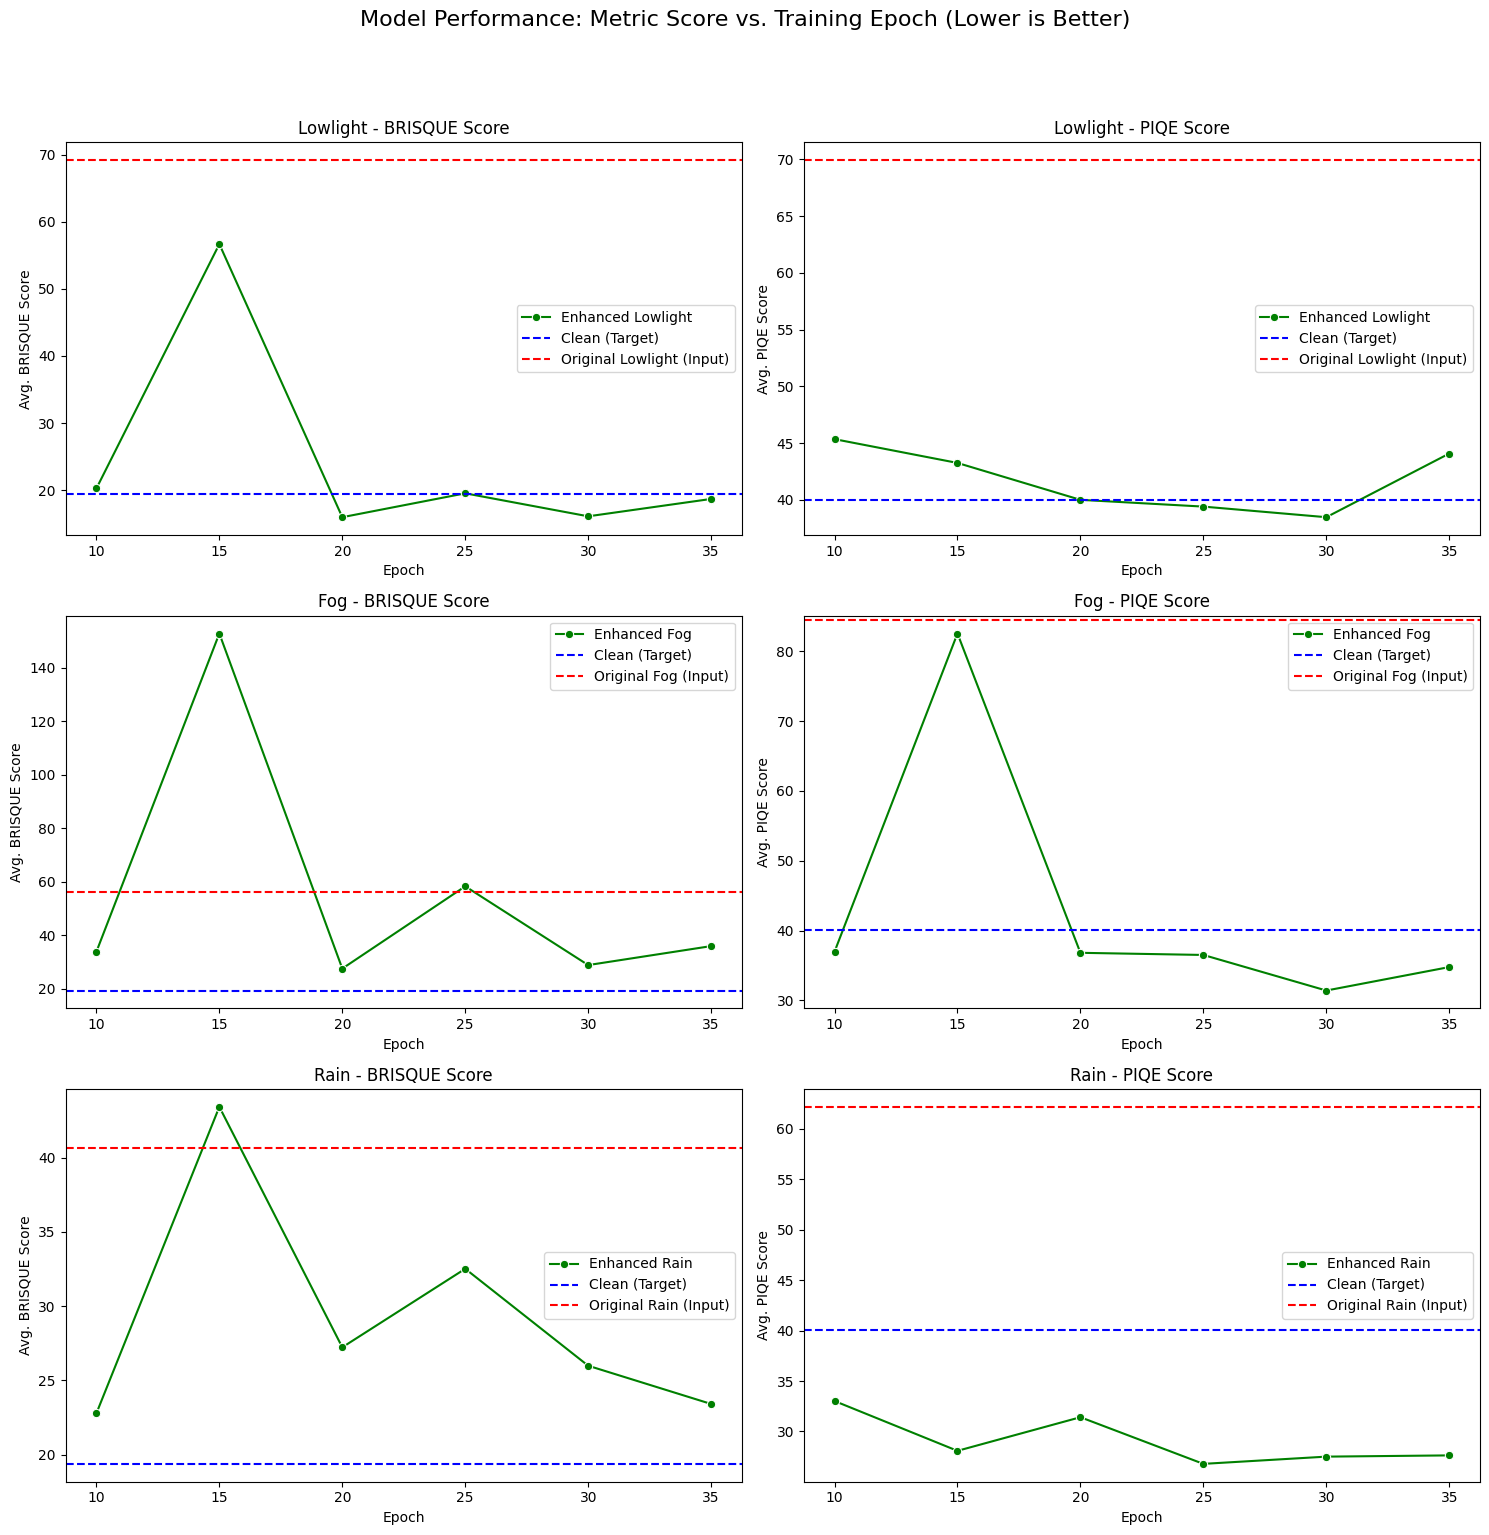

In [24]:
# Cell 7 (Corrected): Plotting Performance vs. Epochs

if not df_results.empty:
    print("\n--- Plotting Performance vs. Epoch ---")
    # Create a new DataFrame for plotting
    plot_df = df_results.copy()
    
    # Simplify categories for plotting
    def get_plot_cat(row):
        if "Clean" in row['Category']:
            return 'Clean'
        if "Original" in row['Category']:
            return 'Degraded'
        if "Epoch" in row['Category']:
            return 'Enhanced'
        return 'Other'

    plot_df['Plot_Category'] = plot_df.apply(get_plot_cat, axis=1)
    
    # Get the base degradation type (Fog, Rain, etc.)
    def get_base_cat(row):
        if 'Fog' in row['Category']: return 'Fog'
        if 'Rain' in row['Category']: return 'Rain'
        if 'Lowlight' in row['Category']: return 'Lowlight'
        return 'Clean'
    
    plot_df['Base_Category'] = plot_df.apply(get_base_cat, axis=1)
    plot_df_no_clean = plot_df[plot_df['Base_Category'] != 'Clean']

    # Calculate averages for plotting
    plot_avg_df = plot_df_no_clean.groupby(['Base_Category', 'Plot_Category', 'Epoch']).mean(numeric_only=True).reset_index()
    
    # Get the 'Clean' and 'Degraded' baseline averages
    clean_avg = df_results[df_results['Category'] == 'Clean'].mean(numeric_only=True)
    
    # --- THIS IS THE CORRECTED LINE ---
    # We group 'plot_df' (which has the 'Base_Category' column) instead of 'df_results'
    degraded_avg = plot_df[plot_df['Plot_Category'] == 'Degraded'].groupby('Base_Category').mean(numeric_only=True)
    # --- END OF CORRECTION ---

    # --- Create the plots ---
    base_categories = [c for c in ["Lowlight", "Fog", "Rain"] if c in plot_df_no_clean['Base_Category'].unique()]
    fig_height = 5 * len(base_categories)
    fig, axes = plt.subplots(len(base_categories), 2, figsize=(15, fig_height), squeeze=False)
    
    fig.suptitle('Model Performance: Metric Score vs. Training Epoch (Lower is Better)', fontsize=16, y=1.02)

    for i, base_cat in enumerate(base_categories):
        # Filter data for this base category (e.g., all 'Fog' related)
        cat_plot_data = plot_avg_df[plot_avg_df['Base_Category'] == base_cat]
        enhanced_data = cat_plot_data[cat_plot_data['Plot_Category'] == 'Enhanced']
        
        # Get baselines for this category
        clean_b = clean_avg['BRISQUE']
        clean_p = clean_avg['PIQE']
        deg_b = degraded_avg.loc[base_cat]['BRISQUE']
        deg_p = degraded_avg.loc[base_cat]['PIQE']

        # --- BRISQUE Plot ---
        ax = axes[i, 0]
        sns.lineplot(data=enhanced_data, x='Epoch', y='BRISQUE', ax=ax, marker='o', label=f'Enhanced {base_cat}', color='green')
        ax.axhline(y=clean_b, color='blue', linestyle='--', label=f'Clean (Target)')
        ax.axhline(y=deg_b, color='red', linestyle='--', label=f'Original {base_cat} (Input)')
        ax.set_title(f'{base_cat} - BRISQUE Score')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Avg. BRISQUE Score')
        ax.legend()
        ax.set_xticks(sorted(enhanced_data['Epoch'].unique())) # Ensure all epochs are ticks

        # --- PIQE Plot ---
        ax = axes[i, 1]
        sns.lineplot(data=enhanced_data, x='Epoch', y='PIQE', ax=ax, marker='o', label=f'Enhanced {base_cat}', color='green')
        ax.axhline(y=clean_p, color='blue', linestyle='--', label=f'Clean (Target)')
        ax.axhline(y=deg_p, color='red', linestyle='--', label=f'Original {base_cat} (Input)')
        ax.set_title(f'{base_cat} - PIQE Score')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Avg. PIQE Score')
        ax.legend()
        ax.set_xticks(sorted(enhanced_data['Epoch'].unique())) # Ensure all epochs are ticks

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

else:
    print("No data to plot.")